# Skin Lesion Binary Classifier
Este cuaderno entrena un modelo CNN para distinguir entre **exantema** y **urticaria**.
Puedes ejecutar las celdas paso a paso o todo seguido.

In [1]:

from __future__ import annotations

import random
import pathlib
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow import keras
from tensorflow.keras import layers

SEED: int = 123
IMG_SIZE: Tuple[int, int] = (128, 128)
BATCH_SIZE: int = 32
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = ["Exanthem", "Urticaria"]


In [2]:


def set_seed(seed: int = SEED) -> None:
    pass
"""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()  # para reproducibilidad inmediata
"""


'\n    random.seed(seed)\n    np.random.seed(seed)\n    tf.random.set_seed(seed)\n\nset_seed()  # para reproducibilidad inmediata\n'

In [3]:

def get_datasets(
    data_dir: str | pathlib.Path,
    image_size: Tuple[int, int] = IMG_SIZE,
    batch_size: int = BATCH_SIZE,
    val_split: float = 0.2,
    seed: int = SEED,
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """
    Devuelve los datasets de entrenamiento, validación y test
    normalizados y con `prefetch` para rendimiento.
    """
    data_dir = pathlib.Path(data_dir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir / "train",
        validation_split=val_split,
        subset="training",
        seed=seed,
        label_mode="binary",
        batch_size=batch_size,
        image_size=image_size,
    )
    val_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir / "train",
        validation_split=val_split,
        subset="validation",
        seed=seed,
        label_mode="binary",
        batch_size=batch_size,
        image_size=image_size,
    )
    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir / "test",
        shuffle=False,
        label_mode="binary",
        batch_size=batch_size,
        image_size=image_size,
    )

    normalization_layer = layers.Rescaling(1.0 / 255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

    return (
        train_ds.prefetch(AUTOTUNE),
        val_ds.prefetch(AUTOTUNE),
        test_ds.prefetch(AUTOTUNE),
    )


In [4]:

def build_model(input_shape: tuple[int, int, int] = (*IMG_SIZE, 3)) -> keras.Model:
    """Crea una CNN sencilla con capas de normalización y data augmentation."""
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
            layers.GaussianNoise(0.05),
        ],
        name="augmentation",
    )

    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs, name="skin_cnn")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [5]:

def plot_history(history: keras.callbacks.History) -> None:
    """Muestra la curva de accuracy de entrenamiento y validación."""
    import matplotlib.pyplot as plt

    plt.figure(figsize=(8, 5))
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["train", "val"])
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:

def train_and_evaluate(
    data_dir: str | pathlib.Path,
    epochs: int = 30,
    batch_size: int = BATCH_SIZE,
) -> tuple[keras.callbacks.History, keras.Model, tf.data.Dataset]:

    """Orquesta el proceso completo de entrenamiento y evaluación."""
    set_seed()
    train_ds, val_ds, test_ds = get_datasets(data_dir, batch_size=batch_size)
    model = build_model()

    callbacks = [
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(
            filepath="best_model.keras", save_best_only=True, verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1),
    ]

    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)
    plot_history(history)

    loss, acc = model.evaluate(test_ds)
    print(f"Test accuracy: {acc:.3%} – loss: {loss:.4f}")

    # Métricas detalladas
    y_prob = model.predict(test_ds).flatten()
    y_pred = (y_prob > 0.5).astype("int32")
    y_true = np.concatenate([y.numpy() for _, y in test_ds])

    print("\nReporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
    print("Matriz de confusión")
    print(confusion_matrix(y_true, y_pred))

    return history, model, test_ds


In [7]:
# Visualizar predicciones sobre el conjunto de test
def show_predictions(model: keras.Model, test_ds: tf.data.Dataset, class_names=CLASS_NAMES, num_images=10):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(15, num_images * 2))
    for i, (images, labels) in enumerate(test_ds.take(num_images)):
        preds = model.predict(images)
        for j in range(len(images)):
            plt.subplot(num_images, 5, i * 5 + j + 1)
            plt.imshow(images[j].numpy())
            true_label = class_names[int(labels[j])]
            pred_label = class_names[int(preds[j] > 0.5)]
            color = "green" if true_label == pred_label else "red"
            plt.title(f"P: {pred_label}\nR: {true_label}", color=color)
            plt.axis("off")
        if (i + 1) * len(images) >= num_images:
            break
    plt.tight_layout()
    plt.show()


Found 229 files belonging to 2 classes.
Using 184 files for training.
Found 229 files belonging to 2 classes.
Using 45 files for validation.
Found 17 files belonging to 2 classes.
Epoch 1/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.5359 - loss: 1.5382
Epoch 1: val_loss improved from inf to 0.68395, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 463ms/step - accuracy: 0.5385 - loss: 1.5231 - val_accuracy: 0.5778 - val_loss: 0.6839 - learning_rate: 1.0000e-04
Epoch 2/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.5496 - loss: 1.1724
Epoch 2: val_loss improved from 0.68395 to 0.67494, saving model to best_model.keras
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.5518 - loss: 1.1736 - val_accuracy: 0.5778 - val_loss: 0.6749 - learning_rate: 1.0000e-04
Epoch 3/40
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6131 - loss: 0.7830
Epoch 3: val_loss did not improve from 0.67494
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.6156 - loss: 0.7

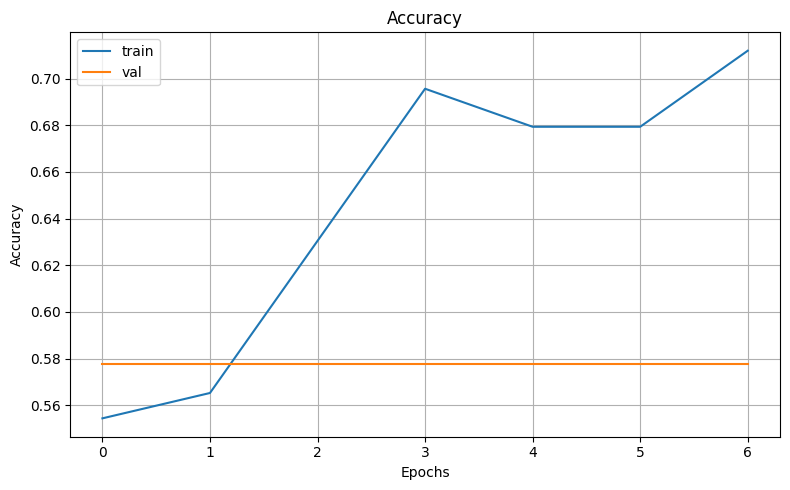

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4706 - loss: 0.7104
Test accuracy: 47.059% – loss: 0.7104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step

Reporte de clasificación:
              precision    recall  f1-score   support

    Exanthem       0.00      0.00      0.00         9
   Urticaria       0.47      1.00      0.64         8

    accuracy                           0.47        17
   macro avg       0.24      0.50      0.32        17
weighted avg       0.22      0.47      0.30        17

Matriz de confusión
[[0 9]
 [0 8]]


c:\Users\Al\Documents\Derma\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Al\Documents\Derma\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Al\Documents\Derma\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


C:\Users\Al\AppData\Local\Temp\ipykernel_7292\4155399829.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_label = class_names[int(preds[j] > 0.5)]


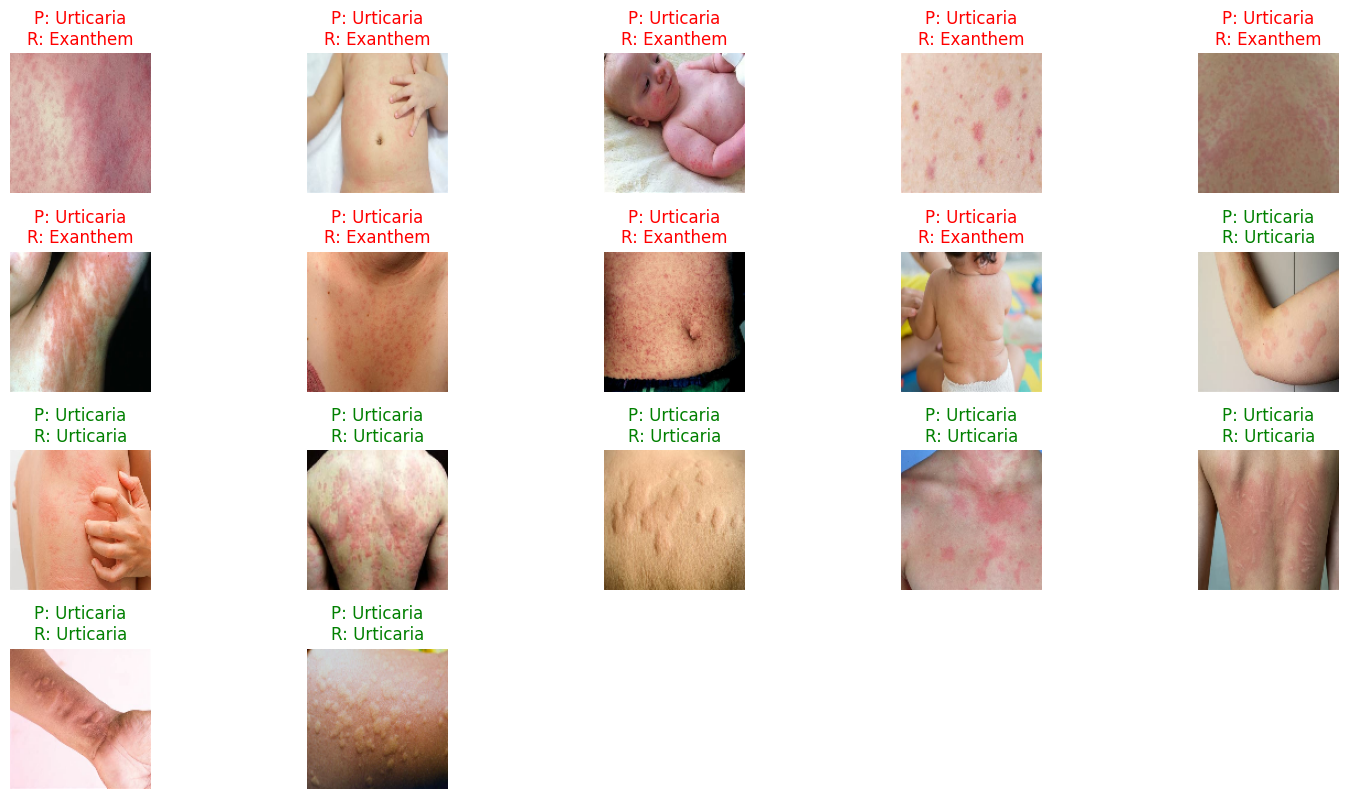

In [8]:
history, model, test_ds = train_and_evaluate("../dataset/binary", epochs=40, batch_size=32)
show_predictions(model, test_ds)